# Semantic-BERT and Semantic-FastText for Bloom's Taxonomy Classification

This notebook implements the methodology for classifying educational questions into Bloom's Taxonomy cognitive levels using enriched semantic representations with BERT and FastText models.

## 1. Environment Setup
First, we install and import the necessary libraries.

In [9]:
# Install dependencies if needed
# !pip install transformers datasets spacy nltk gensim scikit-learn pandas seaborn matplotlib tqdm

import os
import re
import string
import json
import yaml
import pickle
from typing import List, Optional, Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import (
    BertForSequenceClassification, 
    BertTokenizer, 
    get_linear_schedule_with_warmup
)

from gensim.models import FastText
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    confusion_matrix, 
    f1_score, 
    precision_score, 
    recall_score
)

# Download NLTK resources
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab', quiet=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 2. Configuration and Data Loading
We define the configuration and load our dataset. We've added robust path handling to ensure we find your full 3,401 sample dataset.

In [10]:
config = {
    'data': {
        'path': '../data/raw/bloom_questions.csv', # Relative to notebooks/ folder
        'train_ratio': 0.7,
        'val_ratio': 0.15,
        'test_ratio': 0.15,
        'text_column': 'question',
        'label_column': 'level'
    },
    'preprocessing': {
        'lowercase': True,
        'remove_punctuation': True,
        'remove_stopwords': False,
        'lemmatize': True,
        'use_semantic_parsing': True
    },
    'fasttext': {
        'vector_size': 100,
        'epochs': 50,
        'classifier': 'svm'
    },
    'bert': {
        'model_name': 'bert-base-uncased',
        'max_length': 128,
        'batch_size': 16,
        'epochs': 3,
        'learning_rate': 2e-5
    },
    'labels': ["Remember", "Understand", "Apply", "Analyze", "Evaluate", "Create"]
}

# Path Resolution
data_path = config['data']['path']
if not os.path.exists(data_path):
    # Check if we are running from the project root instead of notebooks/ dir
    alt_path = 'data/raw/bloom_questions.csv'
    if os.path.exists(alt_path):
        data_path = alt_path

# Load full data
if os.path.exists(data_path):
    df_raw = pd.read_csv(data_path)
    print(f"SUCCESS: Loaded dataset with {len(df_raw)} samples from {data_path}")
    print("\nClass Distribution:")
    print(df_raw[config['data']['label_column']].value_counts())
    display(df_raw.head())
else:
    print(f"CRITICAL ERROR: Data file not found at {config['data']['path']} or {alt_path}.")
    print("Falling back to dummy data for demonstration purpose ONLY.")
    data = {
        'question': [
            "Define photosynthesis.", 
            "Explain the process of mitosis.", 
            "Use the Pythagorean theorem to solve this.",
            "Compare and contrast two economic systems.",
            "Critique the author's argument.",
            "Design a new experiment to test gravity."
        ] * 20,
        'level': ["Remember", "Understand", "Apply", "Analyze", "Evaluate", "Create"] * 20
    }
    df_raw = pd.DataFrame(data)

SUCCESS: Loaded dataset with 3401 samples from ../data/raw/bloom_questions.csv

Class Distribution:
level
Remember      1231
Understand    1195
Create         407
Evaluate       243
Analyze        213
Apply          112
Name: count, dtype: int64


,question,level
0,Choose the main concepts.,Remember
1,Can you choose this topic?,Remember
2,Please choose the key points.,Remember
3,Define the main concepts.,Remember
4,Can you define this topic?,Remember


## 3. Preprocessing
We implement the `TextPreprocessor` including semantic enrichment (tagging words with dependency info).

In [11]:
class TextPreprocessor:
    def __init__(self, config):
        self.cfg = config
        self.lemmatizer = WordNetLemmatizer() if config['lemmatize'] else None
        self.stop_words = set(stopwords.words('english')) if config['remove_stopwords'] else set()
        
        self.nlp = None
        if config['use_semantic_parsing']:
            import spacy
            try:
                self.nlp = spacy.load("en_core_web_sm")
            except:
                print("SpaCy model 'en_core_web_sm' not found. Downloading...")
                # Download model and load it
                import spacy.cli
                spacy.cli.download("en_core_web_sm")
                self.nlp = spacy.load("en_core_web_sm")
                
    def clean_text(self, text: str) -> str:
        if not isinstance(text, str): return ""
        
        if self.cfg['lowercase']: text = text.lower()
        text = re.sub(r'http\S+|www\.\S+', '', text)
        
        if self.cfg['remove_punctuation']:
            text = text.translate(str.maketrans('', '', string.punctuation))
            
        if self.cfg['use_semantic_parsing'] and self.nlp:
            doc = self.nlp(text)
            tokens = []
            for token in doc:
                if token.is_punct or token.is_space: continue
                word = token.lemma_ if self.cfg['lemmatize'] else token.text
                if self.cfg['lowercase']: word = word.lower()
                # The core of the 'Semantic' approach - adding dependency information
                tokens.append(f"{word}_{token.dep_}")
                tokens.append(token.dep_)
            return ' '.join(tokens)
        
        tokens = word_tokenize(text)
        if self.cfg['remove_stopwords']: 
            tokens = [t for t in tokens if t not in self.stop_words]
        if self.cfg['lemmatize']:
            tokens = [self.lemmatizer.lemmatize(t) for t in tokens]
            
        return ' '.join(tokens)

print("Preprocessing text (this may take a minute for 3,401 samples)...")
preprocessor = TextPreprocessor(config['preprocessing'])
df_proc = df_raw.copy()
df_proc['clean_text'] = df_proc[config['data']['text_column']].apply(preprocessor.clean_text)
df_proc = df_proc.rename(columns={config['data']['label_column']: 'label'})

# Label Encoding
label_to_id = {label: i for i, label in enumerate(config['labels'])}
id_to_label = {i: label for label, i in label_to_id.items()}
df_proc['label_id'] = df_proc['label'].map(label_to_id)

# Train/Val/Test Split with stratification
train_df, temp_df = train_test_split(
    df_proc, train_size=config['data']['train_ratio'], 
    stratify=df_proc['label_id'], random_state=42
)
val_ratio_adj = config['data']['val_ratio'] / (config['data']['val_ratio'] + config['data']['test_ratio'])
val_df, test_df = train_test_split(
    temp_df, train_size=val_ratio_adj, 
    stratify=temp_df['label_id'], random_state=42
)

print(f"\nFinal Dataset Stats:")
print(f"Total: {len(df_proc)}")
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Preprocessing text (this may take a minute for 3,401 samples)...

Final Dataset Stats:
Total: 3401
Train: 2380, Val: 510, Test: 511


## 4. Semantic-FastText Model
We train FastText embeddings and then use an SVM classifier on the averaged sentence vectors.

In [12]:
print("Training FastText embeddings...")
sentences = [text.split() for text in train_df['clean_text']]
ft_model = FastText(
    sentences=sentences, 
    vector_size=config['fasttext']['vector_size'], 
    epochs=config['fasttext']['epochs'], 
    sg=1
)

def get_sentence_vector(text, model):
    words = text.split()
    if not words: return np.zeros(model.vector_size)
    return np.mean([model.wv[w] for w in words], axis=0)

X_train_ft = np.array([get_sentence_vector(t, ft_model) for t in train_df['clean_text']])
X_val_ft = np.array([get_sentence_vector(t, ft_model) for t in val_df['clean_text']])
X_test_ft = np.array([get_sentence_vector(t, ft_model) for t in test_df['clean_text']])

y_train = train_df['label_id'].values
y_val = val_df['label_id'].values
y_test = test_df['label_id'].values

print("Training SVM Classifier (probabilistic RBF kernel)...")
clf = SVC(kernel='rbf', probability=True, class_weight='balanced') # Balanced weights for class imbalance
clf.fit(X_train_ft, y_train)

ft_val_acc = clf.score(X_val_ft, y_val)
print(f"\nFastText Validation Accuracy: {ft_val_acc:.4f}")

Training FastText embeddings...
Training SVM Classifier (probabilistic RBF kernel)...

FastText Validation Accuracy: 0.5118


## 5. Semantic-BERT Model
We fine-tune a BERT-Base model.

In [13]:
class BertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self): return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx], truncation=True, padding='max_length', 
            max_length=self.max_length, return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

tokenizer = BertTokenizer.from_pretrained(config['bert']['model_name'])
bert_model = BertForSequenceClassification.from_pretrained(
    config['bert']['model_name'], num_labels=len(config['labels'])
).to(device)

train_ds = BertDataset(train_df['clean_text'].tolist(), y_train, tokenizer, config['bert']['max_length'])
val_ds = BertDataset(val_df['clean_text'].tolist(), y_val, tokenizer, config['bert']['max_length'])

train_loader = DataLoader(train_ds, batch_size=config['bert']['batch_size'], shuffle=True)
val_loader = DataLoader(val_ds, batch_size=config['bert']['batch_size'])

optimizer = AdamW(bert_model.parameters(), lr=config['bert']['learning_rate'])
total_steps = len(train_loader) * config['bert']['epochs']
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

print("Fine-tuning BERT (this will take longer due to 3,401 samples)...")
for epoch in range(config['bert']['epochs']):
    bert_model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    
    # Validation
    bert_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = bert_model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Epoch {epoch+1} loss: {total_loss/len(train_loader):.4f}, Val Acc: {correct/total:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fine-tuning BERT (this will take longer due to 3,401 samples)...


Epoch 1: 100%|██████████| 149/149 [18:31<00:00,  7.46s/it]


Epoch 1 loss: 1.2101, Val Acc: 0.4059


Epoch 2: 100%|██████████| 149/149 [16:54<00:00,  6.81s/it]


Epoch 2 loss: 1.0533, Val Acc: 0.5745


Epoch 3: 100%|██████████| 149/149 [17:15<00:00,  6.95s/it]


Epoch 3 loss: 0.8990, Val Acc: 0.6294


## 6. Evaluation
Comparison on the test set.


Evaluation results for Semantic-FastText:
              precision    recall  f1-score   support

    Remember       0.67      0.65      0.66       185
  Understand       0.67      0.51      0.58       180
       Apply       0.14      0.06      0.08        17
     Analyze       0.16      0.44      0.24        32
    Evaluate       0.08      0.06      0.07        36
      Create       0.31      0.39      0.35        61

    accuracy                           0.50       511
   macro avg       0.34      0.35      0.33       511
weighted avg       0.54      0.50      0.51       511



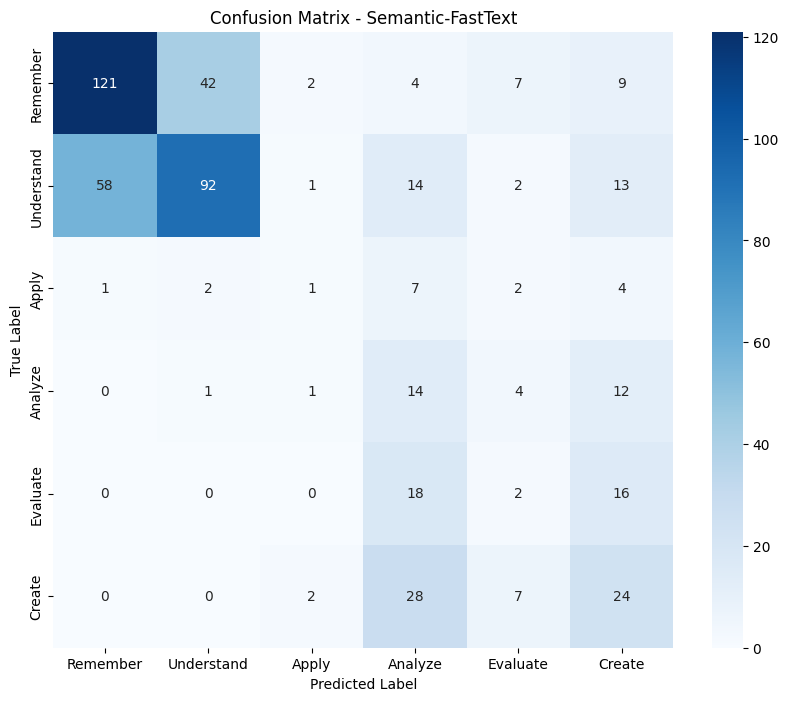

BERT Inference: 100%|██████████| 32/32 [00:46<00:00,  1.45s/it]
c:\Users\MSI\Desktop\SemanticQ\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\MSI\Desktop\SemanticQ\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\MSI\Desktop\SemanticQ\.venv\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa


Evaluation results for Semantic-BERT:
              precision    recall  f1-score   support

    Remember       0.83      0.75      0.78       185
  Understand       0.79      0.77      0.78       180
       Apply       0.00      0.00      0.00        17
     Analyze       0.00      0.00      0.00        32
    Evaluate       0.00      0.00      0.00        36
      Create       0.34      0.93      0.50        61

    accuracy                           0.65       511
   macro avg       0.33      0.41      0.34       511
weighted avg       0.62      0.65      0.62       511



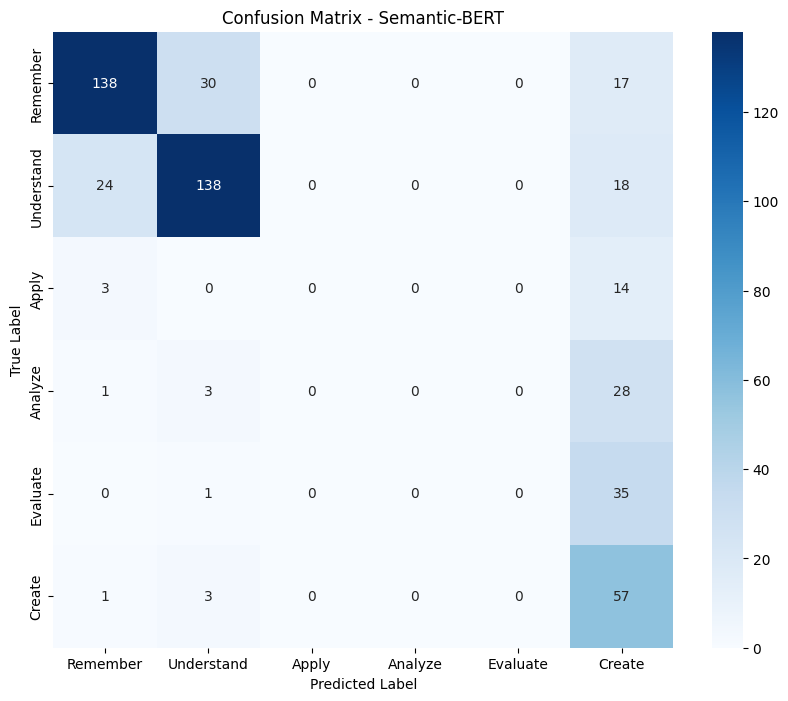

In [14]:
def evaluate_model(y_true, y_pred, name):
    print(f"\nEvaluation results for {name}:")
    print(classification_report(y_true, y_pred, target_names=config['labels']))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=config['labels'], yticklabels=config['labels'])
    plt.title(f"Confusion Matrix - {name}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# FastText Predictions
ft_preds = clf.predict(X_test_ft)
evaluate_model(y_test, ft_preds, "Semantic-FastText")

# BERT Predictions
test_ds = BertDataset(test_df['clean_text'].tolist(), y_test, tokenizer, config['bert']['max_length'])
test_loader = DataLoader(test_ds, batch_size=config['bert']['batch_size'])

bert_model.eval()
bert_preds = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="BERT Inference"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        bert_preds.extend(preds)

evaluate_model(y_test, np.array(bert_preds), "Semantic-BERT")

## 7. Model Comparison
Summary of metrics.

,Model,Accuracy,F1 (Weighted)
0,Semantic-FastText,0.497065,0.508173
1,Semantic-BERT,0.651663,0.616899


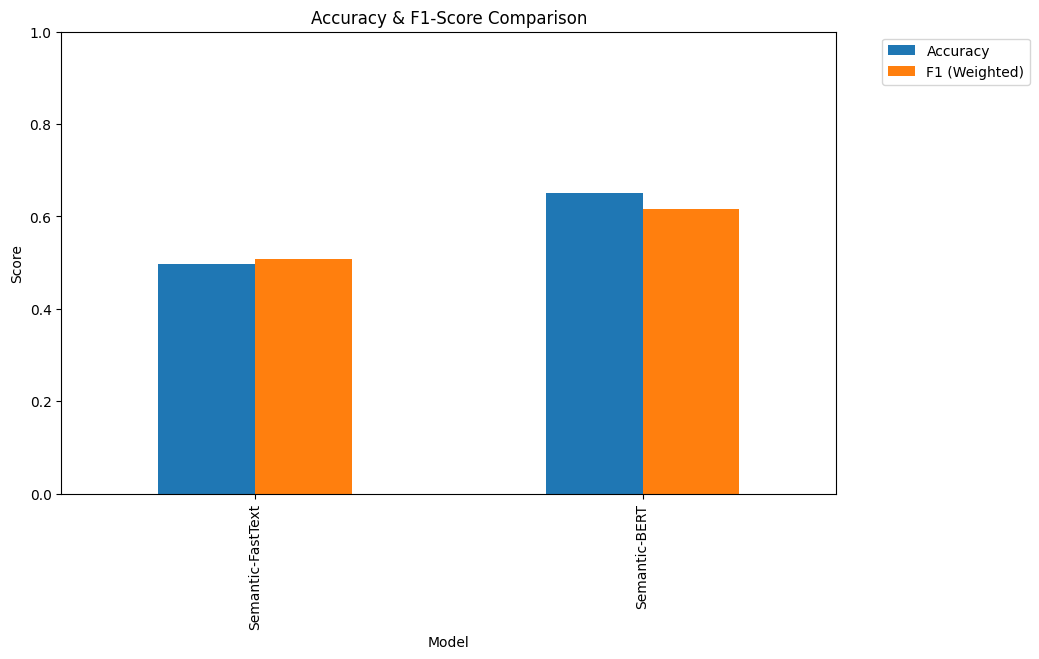

In [15]:
results = {
    'Model': ['Semantic-FastText', 'Semantic-BERT'],
    'Accuracy': [
        accuracy_score(y_test, ft_preds),
        accuracy_score(y_test, bert_preds)
    ],
    'F1 (Weighted)': [
        f1_score(y_test, ft_preds, average='weighted'),
        f1_score(y_test, bert_preds, average='weighted')
    ]
}

df_res = pd.DataFrame(results)
display(df_res)

df_res.plot(x='Model', kind='bar', figsize=(10, 6))
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title("Accuracy & F1-Score Comparison")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## 8. Single Question Inference
Test the models with a new question.

In [16]:
def predict_question(question):
    clean_q = preprocessor.clean_text(question)
    
    # FastText Prediction
    vec = get_sentence_vector(clean_q, ft_model).reshape(1, -1)
    ft_idx = clf.predict(vec)[0]
    ft_prob = np.max(clf.predict_proba(vec))
    ft_label = id_to_label[ft_idx]
    
    # BERT Prediction
    inputs = tokenizer(clean_q, return_tensors='pt', truncation=True, padding='max_length', max_length=128).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
        bert_idx = torch.argmax(outputs.logits, dim=1).item()
        bert_prob = torch.softmax(outputs.logits, dim=1).max().item()
    bert_label = id_to_label[bert_idx]
    
    print(f"\nQuestion: \"{question}\"")
    print(f"  → FastText: {ft_label} ({ft_prob:.2%})")
    print(f"  → BERT:     {bert_label} ({bert_prob:.2%})")

# Sample tests
predict_question("Can you describe the components of an atom?")
predict_question("How would you categorize the main themes of the story?")
predict_question("Create a hypothetical scenario where the law of gravity is reversed.")


Question: "Can you describe the components of an atom?"
  → FastText: Apply (42.23%)
  → BERT:     Understand (44.82%)

Question: "How would you categorize the main themes of the story?"
  → FastText: Apply (41.08%)
  → BERT:     Understand (63.32%)

Question: "Create a hypothetical scenario where the law of gravity is reversed."
  → FastText: Remember (65.94%)
  → BERT:     Remember (63.01%)
